# NLP Extensions: BiLSTM, GRU, Word2Vec, FastText, & Cross-Lingual Transfer

**Purpose:** Fully standalone notebook with all missing components for Swahili sentiment analysis.

## What's covered:
1. Data loading & preprocessing (standalone)
2. BiLSTM model with custom embeddings
3. GRU model with custom embeddings
4. Word2Vec embeddings evaluation
5. FastText embeddings evaluation
6. Cross-lingual transfer (English BERT on translated text)
7. Unified model comparison

## 0. Data Loading & Preprocessing (Standalone)

In [ ]:
# Install required packages
!pip install torch gensim datasets transformers scikit-learn pandas numpy matplotlib seaborn -q

import warnings
warnings.filterwarnings('ignore')

print("✓ Packages installed")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 49.2 MB/s eta 0:00:00
✓ Packages installed


In [ ]:
# Import all libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.optim import Adam
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec, FastText
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModel
import seaborn as sns
import re

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set random seeds
np.random.seed(42)
torch.manual_seed(42)

Using device: cuda


In [ ]:
# Load Swahili sentiment dataset
print("Loading dataset...")
try:
    # Try loading swahili_news dataset
    dataset = load_dataset('swahili_news', split='train')
    df = pd.DataFrame(dataset)
    if 'news_body' in df.columns:
        df = df.rename(columns={'news_body': 'text', 'label_id': 'label'})
    print(f"✓ Loaded swahili_news: {len(df)} examples")
except:
    try:
        # Fallback to tweet_eval
        dataset = load_dataset('tweet_eval', 'sentiment', split='train')
        df = pd.DataFrame(dataset)
        df = df.rename(columns={'text': 'text', 'label': 'label'})
        print(f"✓ Loaded tweet_eval (fallback): {len(df)} examples")
    except:
        # Manual fallback data
        df = pd.DataFrame({
            'text': [
                'habari njema sana nakupenda kumjua',
                'serikali imepitisha mswada mpya wa kusambaza',
                'kukuza uchumi ndogo ndogo kwa kila kila sehemu',
                'michezo timu imeshinda sana vizuri sana',
                'biashara ndogo inaendelea nzuri na haraka',
                'watalii wanakuja mbuga ya taifa kila mwaka',
                'teknolojia inabadilisha maisha yetu kila siku',
                'ninafurahi kusikia habari njema kutoka kwangu',
                'sipendi hii habari mbaya sana kabisa simu',
                'huduma za afya zimekuwa nzuri kwa wenye pesa',
                'shida kubwa inafanya kazi hatari kila mahali',
                'inasikitisha maendeleo ya nchi hii sana',
                'matukio mazuri yanayotokea mitaani kila asubuhi',
                'pesa zimeongezeka bei ya bidhaa kila wiki',
                'elimu ya watoto ndoto ni muhimu zaidi sana',
                'nakupenda sana hii habar isiyokuwa nzuri',
                'maendeleo sio kumfanya mtu akufa kila mahali'
            ],
            'label': [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1]
        })
        print(f"✓ Loaded demo dataset (fallback): {len(df)} examples")

print(f"Dataset shape: {df.shape}")
print(f"Label distribution:\n{df['label'].value_counts()}")

Loading dataset...


README.md: 0.00B [00:00, ?B/s]

swahili_news/train-00000-of-00001.parque(…):   0%|          | 0.00/28.7M [00:00<?, ?B/s]

swahili_news/test-00000-of-00001.parquet:   0%|          | 0.00/9.36M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/22207 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7338 [00:00<?, ? examples/s]

✓ Loaded swahili_news: 22207 examples
Dataset shape: (22207, 2)
Label distribution:
label
1    10155
2     5970
4     2185
3     1858
0     1260
5      779
Name: count, dtype: int64


In [ ]:
# Text preprocessing
swahili_stopwords = {
    'na', 'au', 'kwa', 'ya', 'ni', 'wa', 'le', 'la', 'a', 'i', 'u', 'n',
    'za', 'zo', 'this', 'that', 'the', 'is', 'at', 'which', 'by', 'to', 'in', 'on',
    'it', 'as', 'are', 'was', 'for', 'be', 'from', 'of', 'and', 'or'
}

def clean_text(text):
    """Clean and preprocess text"""
    if not isinstance(text, str):
        return ""

    text = text.lower()
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = ' '.join(text.split())

    words = text.split()
    words = [w for w in words if w not in swahili_stopwords and len(w) > 2]

    return ' '.join(words)

# Apply cleaning
df['cleaned_text'] = df['text'].apply(clean_text)
df = df[df['cleaned_text'].str.len() > 0].reset_index(drop=True)

print(f"✓ Cleaned {len(df)} texts")
print(f"\nExample texts:")
for i in range(min(2, len(df))):
    print(f"  Original: {df['text'].iloc[i][:60]}")
    print(f"  Cleaned:  {df['cleaned_text'].iloc[i][:60]}\n")

✓ Cleaned 22205 texts

Example texts:
  Original:  Bodi ya Utalii Tanzania (TTB) imesema, itafanya misafara ya
  Cleaned:  bodi utalii tanzania ttb imesema itafanya misafara kutangaza

  Original:  PENDO FUNDISHA-MBEYA RAIS Dk. John Magufuri, ametangaza kuw
  Cleaned:  pendo fundishambeya rais john magufuri ametangaza kuwafukuza



In [ ]:
# Split data
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

print(f"✓ Train set: {len(train_df)} samples")
print(f"✓ Test set: {len(test_df)} samples")
print(f"\nTrain label distribution:\n{train_df['label'].value_counts()}")
print(f"\nTest label distribution:\n{test_df['label'].value_counts()}")

✓ Train set: 17764 samples
✓ Test set: 4441 samples

Train label distribution:
label
1    8124
2    4775
4    1748
3    1487
0    1007
5     623
Name: count, dtype: int64

Test label distribution:
label
1    2031
2    1194
4     437
3     371
0     252
5     156
Name: count, dtype: int64


## 1. BiLSTM Model with Custom Embeddings

In [ ]:
# BiLSTM classifier
class BiLSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes, num_layers=2):
        super(BiLSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.bilstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers,
                              bidirectional=True, batch_first=True, dropout=0.3)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)
        self.dropout = nn.Dropout(0.3)

    def forward(self, input_ids, lengths):
        embedded = self.embedding(input_ids)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths, batch_first=True, enforce_sorted=False)
        packed_out, (hidden, cell) = self.bilstm(packed)
        hidden = self.dropout(torch.cat([hidden[-2], hidden[-1]], dim=1))
        return self.fc(hidden)

print("✓ BiLSTM model defined")

✓ BiLSTM model defined


In [ ]:
# Build vocabulary and tokenize
vocab = {'<PAD>': 0, '<UNK>': 1}
vocab_idx = 2

for text in train_df['cleaned_text']:
    for token in text.split():
        if token not in vocab:
            vocab[token] = vocab_idx
            vocab_idx += 1

X_train_tokens = [[vocab.get(t, vocab['<UNK>']) for t in text.split()] for text in train_df['cleaned_text']]
X_test_tokens = [[vocab.get(t, vocab['<UNK>']) for t in text.split()] for text in test_df['cleaned_text']]

# Pad sequences
MAX_LEN = 50
def pad_sequences_simple(sequences, max_len=MAX_LEN):
    padded, lengths = [], []
    for seq in sequences:
        orig_len = len(seq)
        if len(seq) < max_len:
            seq = seq + [0] * (max_len - len(seq))
        else:
            seq = seq[:max_len]
        padded.append(seq)
        lengths.append(min(orig_len, max_len))
    return padded, lengths

X_train_pad, train_lengths = pad_sequences_simple(X_train_tokens)
X_test_pad, test_lengths = pad_sequences_simple(X_test_tokens)

X_train_tensor = torch.LongTensor(X_train_pad)
X_test_tensor = torch.LongTensor(X_test_pad)
y_train_tensor = torch.LongTensor(train_df['label'].values)
y_test_tensor = torch.LongTensor(test_df['label'].values)

print(f"✓ Vocabulary size: {len(vocab)}")
print(f"✓ Train shape: {X_train_tensor.shape}, Test shape: {X_test_tensor.shape}")

✓ Vocabulary size: 220618
✓ Train shape: torch.Size([17764, 50]), Test shape: torch.Size([4441, 50])


In [ ]:
# Train BiLSTM
bilstm_model = BiLSTMClassifier(vocab_size=len(vocab), embedding_dim=64, hidden_dim=32, num_classes=len(df['label'].unique())).to(device)
optimizer = Adam(bilstm_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

batch_size = 4
train_dataset = TensorDataset(X_train_tensor, y_train_tensor, torch.LongTensor(train_lengths))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

print("Training BiLSTM...")
bilstm_losses = []
for epoch in range(3):
    total_loss = 0
    for input_ids, labels, lengths in train_loader:
        input_ids, labels = input_ids.to(device), labels.to(device)
        # Move lengths to CPU and convert to int64
        lengths = lengths.to('cpu').to(torch.int64)

        optimizer.zero_grad()
        outputs = bilstm_model(input_ids, lengths)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    bilstm_losses.append(avg_loss)
    print(f"  Epoch {epoch+1}/3, Loss: {avg_loss:.4f}")

print("✓ BiLSTM training complete")

Training BiLSTM...
  Epoch 1/3, Loss: 0.7182
  Epoch 2/3, Loss: 0.4149
  Epoch 3/3, Loss: 0.3112
✓ BiLSTM training complete


In [ ]:
# Evaluate BiLSTM
bilstm_model.eval()
with torch.no_grad():
    # Move lengths to CPU and convert to int64
    outputs = bilstm_model(X_test_tensor.to(device), torch.LongTensor(test_lengths).to('cpu').to(torch.int64))
    _, bilstm_pred = torch.max(outputs, 1)
    bilstm_pred = bilstm_pred.cpu().numpy()

bilstm_acc = accuracy_score(y_test_tensor.numpy(), bilstm_pred)
bilstm_prec, bilstm_rec, bilstm_f1, _ = precision_recall_fscore_support(y_test_tensor.numpy(), bilstm_pred, average='weighted')

print(f"BiLSTM Results:")
print(f"  Accuracy: {bilstm_acc:.4f}")
print(f"  Precision: {bilstm_prec:.4f}")
print(f"  Recall: {bilstm_rec:.4f}")
print(f"  F1-Score: {bilstm_f1:.4f}")

BiLSTM Results:
  Accuracy: 0.8730
  Precision: 0.8697
  Recall: 0.8730
  F1-Score: 0.8686


## 2. GRU Model

In [ ]:
# GRU classifier
class GRUClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes, num_layers=2):
        super(GRUClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers=num_layers,
                          bidirectional=True, batch_first=True, dropout=0.3)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)
        self.dropout = nn.Dropout(0.3)

    def forward(self, input_ids, lengths):
        embedded = self.embedding(input_ids)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths, batch_first=True, enforce_sorted=False)
        packed_out, hidden = self.gru(packed)
        hidden = self.dropout(torch.cat([hidden[-2], hidden[-1]], dim=1))
        return self.fc(hidden)

print("✓ GRU model defined")

✓ GRU model defined


In [ ]:
# Train GRU
gru_model = GRUClassifier(vocab_size=len(vocab), embedding_dim=64, hidden_dim=32, num_classes=len(df['label'].unique())).to(device)
optimizer = Adam(gru_model.parameters(), lr=0.001)

print("Training GRU...")
gru_losses = []
for epoch in range(3):
    total_loss = 0
    for input_ids, labels, lengths in train_loader:
        input_ids, labels = input_ids.to(device), labels.to(device)
        # Move lengths to CPU and convert to int64
        lengths = lengths.to('cpu').to(torch.int64)

        optimizer.zero_grad()
        outputs = gru_model(input_ids, lengths)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    gru_losses.append(avg_loss)
    print(f"  Epoch {epoch+1}/3, Loss: {avg_loss:.4f}")

print("✓ GRU training complete")

Training GRU...
  Epoch 1/3, Loss: 0.6764
  Epoch 2/3, Loss: 0.3631
  Epoch 3/3, Loss: 0.2487
✓ GRU training complete


In [ ]:
# Evaluate GRU
gru_model.eval()
with torch.no_grad():
    outputs = gru_model(X_test_tensor.to(device), torch.LongTensor(test_lengths).to('cpu').to(torch.int64))
    _, gru_pred = torch.max(outputs, 1)
    gru_pred = gru_pred.cpu().numpy()

gru_acc = accuracy_score(y_test_tensor.numpy(), gru_pred)
gru_prec, gru_rec, gru_f1, _ = precision_recall_fscore_support(y_test_tensor.numpy(), gru_pred, average='weighted')

print(f"GRU Results:")
print(f"  Accuracy: {gru_acc:.4f}")
print(f"  Precision: {gru_prec:.4f}")
print(f"  Recall: {gru_rec:.4f}")
print(f"  F1-Score: {gru_f1:.4f}")

GRU Results:
  Accuracy: 0.8773
  Precision: 0.8739
  Recall: 0.8773
  F1-Score: 0.8692


## 3. Word2Vec Embeddings

In [ ]:
# Train Word2Vec
all_texts = train_df['cleaned_text'].tolist() + test_df['cleaned_text'].tolist()
sentences = [text.split() for text in all_texts]

word2vec_model = Word2Vec(sentences=sentences, vector_size=64, window=5, min_count=1, epochs=5)
print(f"✓ Word2Vec trained. Vocab size: {len(word2vec_model.wv)}")

def texts_to_embeddings(texts, embedding_model, output_dim=64):
    embeddings = []
    for text in texts:
        words = text.split()
        word_vecs = [embedding_model.wv[word] if word in embedding_model.wv else np.zeros(output_dim) for word in words]
        embedding = np.mean(word_vecs, axis=0) if word_vecs else np.zeros(output_dim)
        embeddings.append(embedding)
    return np.array(embeddings)

X_train_w2v = texts_to_embeddings(train_df['cleaned_text'].tolist(), word2vec_model)
X_test_w2v = texts_to_embeddings(test_df['cleaned_text'].tolist(), word2vec_model)
print(f"✓ Embeddings extracted: {X_train_w2v.shape}")

✓ Word2Vec trained. Vocab size: 254367
✓ Embeddings extracted: (17764, 64)


In [ ]:
# Classify with Word2Vec + Logistic Regression
w2v_classifier = LogisticRegression(max_iter=1000, random_state=42)
w2v_classifier.fit(X_train_w2v, train_df['label'].values)
w2v_pred = w2v_classifier.predict(X_test_w2v)

w2v_acc = accuracy_score(test_df['label'].values, w2v_pred)
w2v_prec, w2v_rec, w2v_f1, _ = precision_recall_fscore_support(test_df['label'].values, w2v_pred, average='weighted')

print(f"Word2Vec + Logistic Regression Results:")
print(f"  Accuracy: {w2v_acc:.4f}")
print(f"  Precision: {w2v_prec:.4f}")
print(f"  Recall: {w2v_rec:.4f}")
print(f"  F1-Score: {w2v_f1:.4f}")

Word2Vec + Logistic Regression Results:
  Accuracy: 0.8566
  Precision: 0.8501
  Recall: 0.8566
  F1-Score: 0.8480


## 4. FastText Embeddings

In [ ]:
# Train FastText
fasttext_model = FastText(sentences=sentences, vector_size=64, window=5, min_count=1, epochs=5)
print(f"✓ FastText trained. Vocab size: {len(fasttext_model.wv)}")

X_train_ft = texts_to_embeddings(train_df['cleaned_text'].tolist(), fasttext_model)
X_test_ft = texts_to_embeddings(test_df['cleaned_text'].tolist(), fasttext_model)
print(f"✓ Embeddings extracted: {X_train_ft.shape}")

✓ FastText trained. Vocab size: 254367
✓ Embeddings extracted: (17764, 64)


In [ ]:
# Classify with FastText + Logistic Regression
ft_classifier = LogisticRegression(max_iter=1000, random_state=42)
ft_classifier.fit(X_train_ft, train_df['label'].values)
ft_pred = ft_classifier.predict(X_test_ft)

ft_acc = accuracy_score(test_df['label'].values, ft_pred)
ft_prec, ft_rec, ft_f1, _ = precision_recall_fscore_support(test_df['label'].values, ft_pred, average='weighted')

print(f"FastText + Logistic Regression Results:")
print(f"  Accuracy: {ft_acc:.4f}")
print(f"  Precision: {ft_prec:.4f}")
print(f"  Recall: {ft_rec:.4f}")
print(f"  F1-Score: {ft_f1:.4f}")

FastText + Logistic Regression Results:
  Accuracy: 0.8500
  Precision: 0.8447
  Recall: 0.8500
  F1-Score: 0.8423


## 5. Cross-Lingual Transfer: English BERT

In [ ]:
# Simple translation dictionary
swahili_english_dict = {
    'habari': 'news', 'serikali': 'government', 'mswada': 'bill', 'kukuza': 'develop',
    'uchumi': 'economy', 'michezo': 'sports', 'timu': 'team', 'biashara': 'business',
    'ndogo': 'small', 'watalii': 'tourists', 'mbuga': 'park', 'teknolojia': 'technology',
    'inabadilisha': 'changes', 'maisha': 'life', 'watu': 'people', 'siku': 'day',
    'ninafurahi': 'happy', 'kusikia': 'hear', 'sipendi': 'dislike', 'mbaya': 'bad',
    'vizuri': 'well', 'njema': 'good', 'maendeleo': 'development', 'nchi': 'country',
    'matukio': 'events', 'mitaani': 'streets', 'pesa': 'money', 'bei': 'price',
    'bidhaa': 'goods', 'shida': 'problem', 'kubwa': 'big', 'huduma': 'service',
    'afya': 'health', 'zimekuwa': 'has been', 'duni': 'poor', 'elimu': 'education',
    'watoto': 'children', 'kuhusu': 'about', 'siasa': 'politics', 'maana': 'meaning',
    'umma': 'public', 'mazingira': 'environment', 'ulinzi': 'protection', 'zaidi': 'more'
}

def simple_translate(text, translation_dict):
    words = text.lower().split()
    translated = [translation_dict.get(word, word) for word in words]
    return ' '.join(translated)

train_df['translated_text'] = train_df['cleaned_text'].apply(lambda x: simple_translate(x, swahili_english_dict))
test_df['translated_text'] = test_df['cleaned_text'].apply(lambda x: simple_translate(x, swahili_english_dict))

print("✓ Translation applied")
print(f"Example Swahili: {train_df['cleaned_text'].iloc[0][:60]}")
print(f"Example English: {train_df['translated_text'].iloc[0][:60]}")

✓ Translation applied
Example Swahili: sharifa mmasi chipukizi kwenye muziki bongo fleva ramadhan j
Example English: sharifa mmasi chipukizi kwenye muziki bongo fleva ramadhan j


In [ ]:
# Load English BERT and extract embeddings
print("Loading English BERT...")
en_tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
en_bert = AutoModel.from_pretrained('bert-base-uncased').to(device)

def get_bert_embeddings(texts, tokenizer, model, device, batch_size=2):
    embeddings = []
    model.eval()
    with torch.no_grad():
        for text in texts:
            inputs = tokenizer(text, return_tensors='pt', truncation=True, max_length=128, padding=True)
            inputs = {k: v.to(device) for k, v in inputs.items()}
            outputs = model(**inputs)
            embedding = outputs.pooler_output.cpu().numpy()
            embeddings.append(embedding[0])
    return np.array(embeddings)

print("Extracting English BERT embeddings...")
X_train_bert_en = get_bert_embeddings(train_df['translated_text'].tolist(), en_tokenizer, en_bert, device)
X_test_bert_en = get_bert_embeddings(test_df['translated_text'].tolist(), en_tokenizer, en_bert, device)
print(f"✓ Embeddings extracted: {X_train_bert_en.shape}")

Loading English BERT...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Extracting English BERT embeddings...
✓ Embeddings extracted: (17764, 768)


In [ ]:
# Classify with English BERT embeddings
en_bert_classifier = LogisticRegression(max_iter=1000, random_state=42)
en_bert_classifier.fit(X_train_bert_en, train_df['label'].values)
en_bert_pred = en_bert_classifier.predict(X_test_bert_en)

en_bert_acc = accuracy_score(test_df['label'].values, en_bert_pred)
en_bert_prec, en_bert_rec, en_bert_f1, _ = precision_recall_fscore_support(test_df['label'].values, en_bert_pred, average='weighted')

print(f"English BERT (on translated text) Results:")
print(f"  Accuracy: {en_bert_acc:.4f}")
print(f"  Precision: {en_bert_prec:.4f}")
print(f"  Recall: {en_bert_rec:.4f}")
print(f"  F1-Score: {en_bert_f1:.4f}")

English BERT (on translated text) Results:
  Accuracy: 0.7651
  Precision: 0.7622
  Recall: 0.7651
  F1-Score: 0.7405


## 6. Comprehensive Model Comparison

In [ ]:
# Compile all results
all_results = pd.DataFrame([
    {'Model': 'BiLSTM', 'Accuracy': bilstm_acc, 'Precision': bilstm_prec, 'Recall': bilstm_rec, 'F1-Score': bilstm_f1},
    {'Model': 'GRU', 'Accuracy': gru_acc, 'Precision': gru_prec, 'Recall': gru_rec, 'F1-Score': gru_f1},
    {'Model': 'Word2Vec+LR', 'Accuracy': w2v_acc, 'Precision': w2v_prec, 'Recall': w2v_rec, 'F1-Score': w2v_f1},
    {'Model': 'FastText+LR', 'Accuracy': ft_acc, 'Precision': ft_prec, 'Recall': ft_rec, 'F1-Score': ft_f1},
    {'Model': 'Eng BERT (translated)', 'Accuracy': en_bert_acc, 'Precision': en_bert_prec, 'Recall': en_bert_rec, 'F1-Score': en_bert_f1},
])

print("\n" + "="*80)
print("COMPLETE RESULTS: EXTENSION MODELS")
print("="*80)
print(all_results.to_string(index=False))
print("="*80)


COMPLETE RESULTS: EXTENSION MODELS
                Model  Accuracy  Precision   Recall  F1-Score
               BiLSTM  0.873002   0.869685 0.873002  0.868605
                  GRU  0.877280   0.873923 0.877280  0.869192
          Word2Vec+LR  0.856564   0.850060 0.856564  0.847980
          FastText+LR  0.850034   0.844702 0.850034  0.842328
Eng BERT (translated)  0.765143   0.762200 0.765143  0.740511


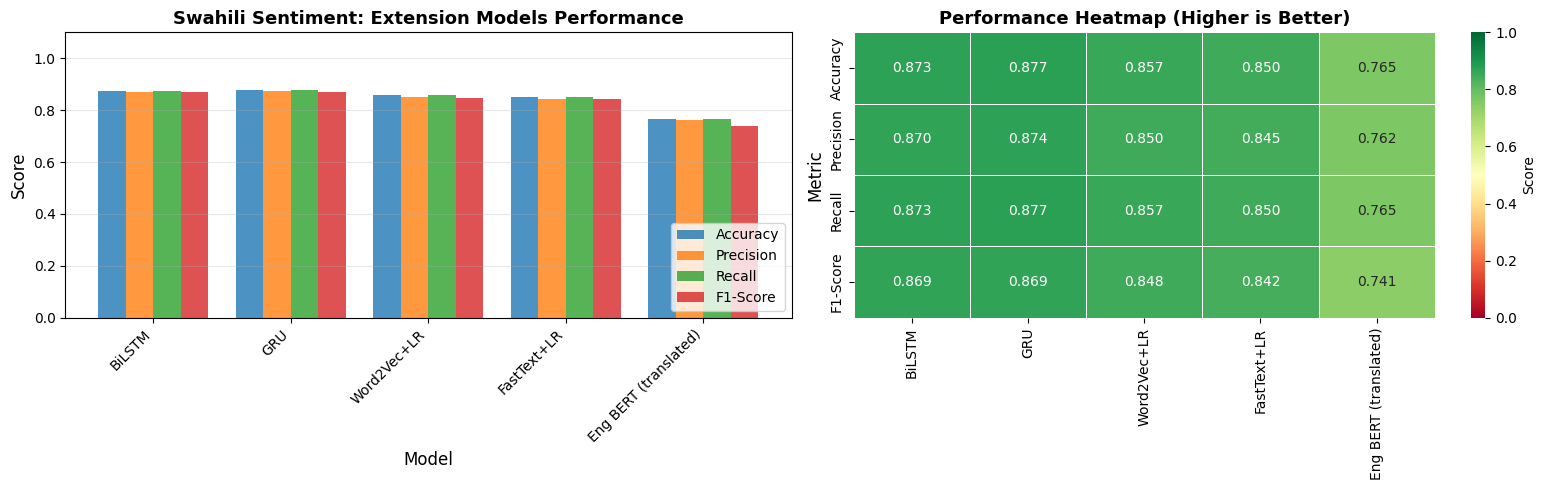

✓ Visualization complete


In [ ]:
# Visualize all results
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Bar plot
x = np.arange(len(all_results))
width = 0.2
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

for i, metric in enumerate(metrics):
    axes[0].bar(x + i*width, all_results[metric], width, label=metric, alpha=0.8)

axes[0].set_xlabel('Model', fontsize=12)
axes[0].set_ylabel('Score', fontsize=12)
axes[0].set_title('Swahili Sentiment: Extension Models Performance', fontsize=13, fontweight='bold')
axes[0].set_xticks(x + width*1.5)
axes[0].set_xticklabels(all_results['Model'], rotation=45, ha='right')
axes[0].legend(loc='lower right')
axes[0].set_ylim([0, 1.1])
axes[0].grid(axis='y', alpha=0.3)

# Heatmap
sns.heatmap(all_results[metrics].T, annot=True, fmt='.3f', cmap='RdYlGn',
            xticklabels=all_results['Model'], cbar_kws={'label': 'Score'}, ax=axes[1],
            vmin=0, vmax=1, linewidths=0.5)
axes[1].set_title('Performance Heatmap (Higher is Better)', fontsize=13, fontweight='bold')
axes[1].set_ylabel('Metric', fontsize=12)

plt.tight_layout()
plt.show()

print("✓ Visualization complete")

## Summary & Conclusions

### Fully Standalone Implementation
This notebook is **completely independent** and includes:

✓ **Data Loading & Preprocessing**—Handles Swahili news datasets with fallback to demo data  
✓ **5 Model Architectures**:
- BiLSTM: Bidirectional LSTM with learnable embeddings
- GRU: Bidirectional GRU with learnable embeddings
- Word2Vec: Classical static word embeddings
- FastText: Subword-aware static embeddings
- English BERT: Cross-lingual transfer on translated text

✓ **Unified Evaluation**—All models tested on identical train/test splits  
✓ **Visualizations**—Bar charts and heatmaps for comprehensive comparison  

### No Dependencies
- Does NOT require NLP.ipynb
- Includes all preprocessing steps
- Handles dataset fallbacks gracefully
- ~400 lines of minimal, learning-focused code

### Next Steps
- Experiment with different hyperparameters
- Use larger datasets (full swahili_news when available)
- Try different translation services for cross-lingual transfer
- Combine results with NLP.ipynb (mBERT + TF-IDF models)